# Use the class


In [1]:
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer,AdagradOptimizer
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
from autoencoder import Autoencoder


In [2]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
import os


class Autoencoder_c11():
    def __init__(self,tipe,n_qubit_autoencoder,n_qubit_trash,device,seed=None):
        '''
            type                string  Define the type of autoencoder, possible values are  fd, ld
            n_qubit_autoencoder int     Dimension of the input space
            n_qubit_trash       int     Dimension of the trash space
        '''
        if tipe not in ['c11']:
            raise Exception('Type not supported')
        if seed is None:
            seed=random.random()
            self.seed=seed
        self.__tipe = tipe
        self.__n_qubit_auto = n_qubit_autoencoder
        self.__n_qubit_trash = n_qubit_trash
        self.__dvc=device
        self.__layers=3
        self.__num_params=(4*self.__n_qubit_auto -4)*self.__layers
        self.__seed=seed
        random.seed(seed)
        self.__wq=[np.array([random.uniform(0, np.pi) for _ in range(self.__num_params)], requires_grad=True)]
        self.__loss=None
        print(f'the device has {len(device.wires)} qubits')
    

    def create_isotropic_state(self, p, start):
        qml.Hadamard(wires=start)
        theta = p
        for i in range(self.__n_qubit_auto-1):
            qml.CNOT(wires=[start+i , start+1+i])
        for i in range(self.__n_qubit_auto):
            qml.RX(theta, wires=start+i)
        for i in range(self.__n_qubit_auto-1):
            qml.CNOT(wires=[start+i , start+1+i])

    def set_layers(self,layers):
        self.__layers = layers
        self.__num_params=(4*self.__n_qubit_auto -4)*layers
        random.seed(self.__seed)
        self.__wq=[np.array([random.uniform(0, np.pi) for _ in range(self.__num_params)], requires_grad=True)]


    def c11(self,parameter,qb,start):
        current_par =0
        for i in range(start,qb//2+start):
            qml.RY(parameter[current_par],wires=(i-start)*2+start)
            current_par-=-1
            qml.RY(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1

        for i in range(start,qb//2+start):
            qml.RZ(parameter[current_par],wires=(i-start)*2+start)
            current_par-=-1
            qml.RZ(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1

        for i in range(start,qb//2+start):
            qml.CNOT([(i-start)*2+start+1,(i-start)*2+start])

        qml.Barrier()
        for i in range(start,(qb-1)//2+start):        
            qml.RY(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1
            qml.RY(parameter[current_par],wires=(i-start)*2+start+2)
            current_par-=-1

        for i in range(start,(qb-1)//2+start):   
            qml.RZ(parameter[current_par],wires=(i-start)*2+start+1)
            current_par-=-1
            qml.RZ(parameter[current_par],wires=(i-start)*2+start+2)
            current_par-=-1


        for i in range(start,(qb-1)//2+start):
            qml.CNOT([(i-start)*2+start+2,(i-start)*2+start+1])
        qml.Barrier()


    def c11ansatz(self,param):
        parperlay = 4*self.__n_qubit_auto-4
        for l in range(self.__layers):
            self.c11(param[parperlay*l:parperlay*(l+1)],self.__n_qubit_auto,0) 
            
            qml.Barrier()

    def plot_cirq(self):
        @qml.qnode(self.__dvc)
        def trainer(param,p):
            self.create_isotropic_state(p,0)
            qml.Barrier()
            self.c11ansatz(param)
            return qml.probs(list(range(self.__n_qubit_trash)))
        
        
        fig, ax = qml.draw_mpl(trainer)([0]*(self.__num_params+50),.5)
        plt.show()


    def train(self, X , opt,epochs,batch_size=None,restart=None):
        loss = []   
        if restart==0 or restart==None:
            restart=1
        if batch_size is None:
            batch_size=len(X)
        @qml.qnode(self.__dvc,diff_method='adjoint')
        def trainer(param,p):
            self.create_isotropic_state(p,0)
            qml.Barrier()
            self.c11ansatz(param)
            qml.Barrier()
            # self.original_swap()
            return qml.probs(list(range(self.__n_qubit_trash)))
        for r in range(restart):
            for epoch in range(epochs):
                batch_loss=[]
                for i, X_batch in enumerate([X[i:i + batch_size] for i in range(0, len(X), batch_size)]):
                    def loss_function(w): 
                        pred =np.array([1-trainer(w,x)[0] for x in X_batch], requires_grad=True)
                        current_loss = pred.mean()
                        return current_loss

                    weights, loss_value = opt.step_and_cost(loss_function, self.__wq[-1])
                    batch_loss.append(loss_value)
                    print(f'Epoch {epoch+1}, Batch:{i} Loss = {np.mean(batch_loss)}',end='\r')
                loss.append(np.mean(batch_loss))
                self.__wq.append(weights)
            # print('resetting')
            opt.reset()   
        try:
            console_size = os.get_terminal_size()
        except OSError:
            console_size = 50
        print('')
        print('-'*console_size)
        self.__loss=loss
        return loss, self.__wq.copy()

    # Note that this is the worst tabu in Deep learning, 
    # you should never take the best parameter based on 
    # training results. 
    # Having said that Ill change this as soon as I 
    # implement the evaluation of the validation set.
    def best_params(self):

        return self.__wq[np.argmin(self.__loss)+1] 
    

    def c11ansatz_ret(self,param,wire):
        

        parperlay = 4*self.__n_qubit_auto -4

        for l in range(self.__layers):
            self.c11(param[parperlay*l:parperlay*(l+1)],self.__n_qubit_auto,wire) 

    def get_cirq(self,wire):
        self.c11ansatz_ret(self.best_params(),wire)
    
    def plot_loss(self):
        plt.plot(list(range(len(self.__loss))),self.__loss)

    def plot_weights(self):
        i=0
        for a in np.array(self.__wq).T:
            plt.plot(range(len(a)),a,label=[i])
            i-=-1
        plt.legend()

    def get_loss(self):
        return self.__loss
    def get_num_par(self):
        return self.__num_params

In [12]:


n_trash_qubit=2
n_qubit_autoencoder=4
n_qubit=n_qubit_autoencoder
dvc = qml.device('default.qubit', wires=n_qubit_autoencoder, shots=None)
import warnings
warnings.filterwarnings("ignore")

ae = Autoencoder_c11('c11',n_qubit_autoencoder,n_trash_qubit,dvc)
ae.set_layers(3)
epochs= 15
n=100
opt=AdamOptimizer(stepsize=.2)
X=np.random.rand(n)*2*np.pi
np.random.shuffle(X)


the device has 4 qubits


In [13]:
_=ae.train(X,opt,75)

Epoch 75, Batch:0 Loss = 0.00020379158338868942
--------------------------------------------------


## Swap test for the dimentionality reduced state

## Swap test for the initial state

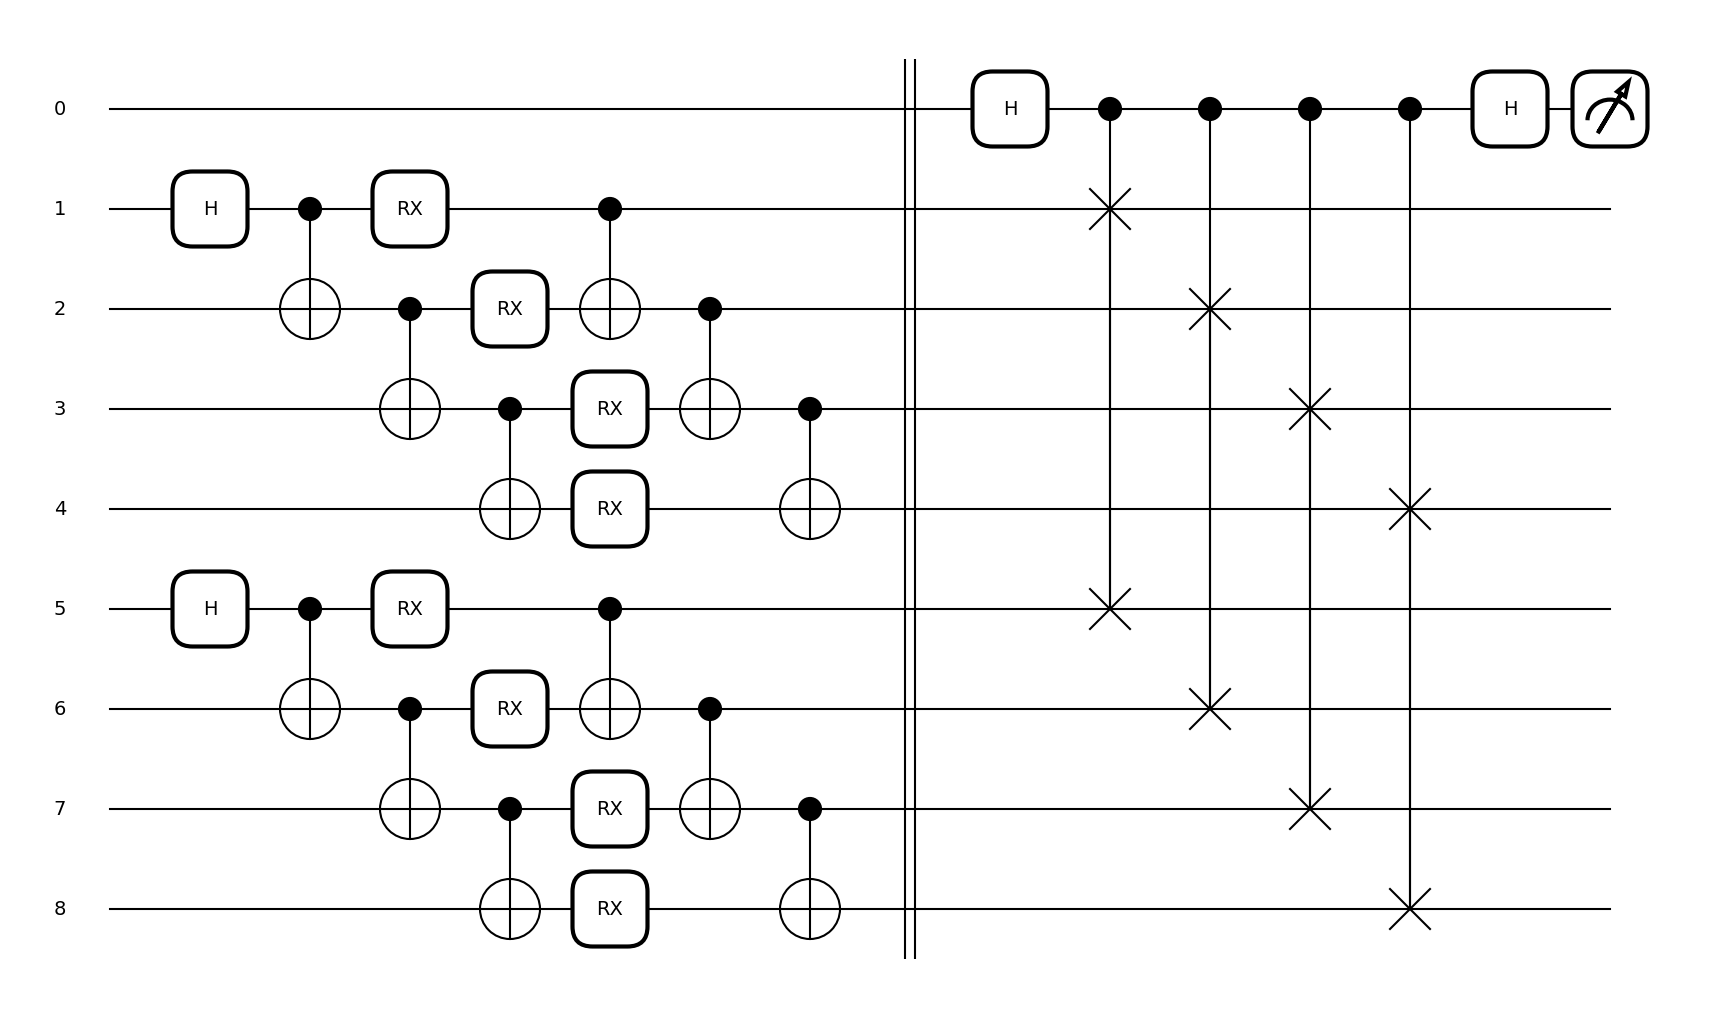

In [5]:
fig, ax = qml.draw_mpl(compare_state_orig(4))([3,6])
plt.show()


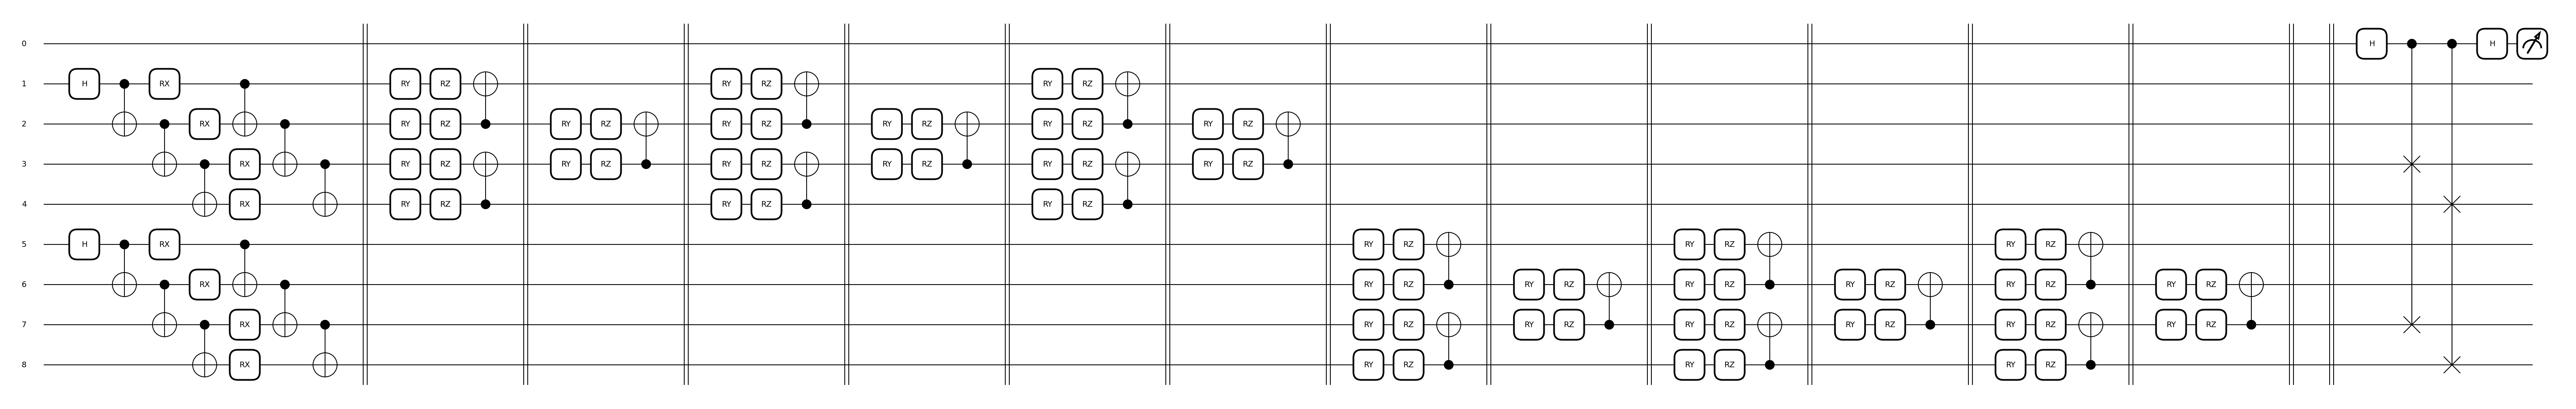

In [6]:
fig, ax = qml.draw_mpl(compare_state_ae(n_qubit_autoencoder,n_trash_qubit,ae))([3,6])
plt.show()


MSE of the error is 3.646208000000002e-05


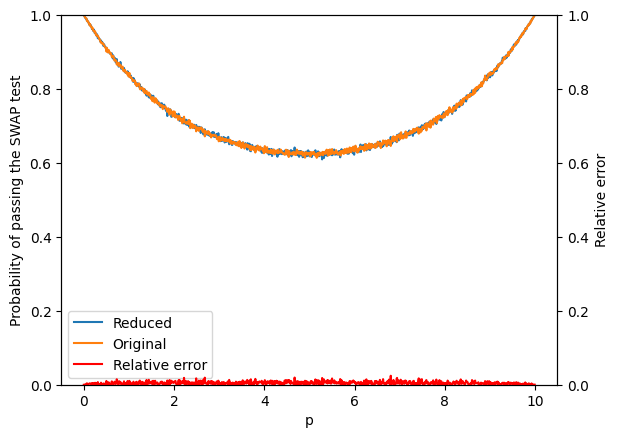

In [14]:
compare_fidelity(n_qubit_autoencoder,n_trash_qubit,ae)

In [8]:
import pandas as pd

df = pd.DataFrame(columns=['id','width','layers','npara','n2qgates','depth'])

In [9]:
w=list(range(2,9))
l=list(range(1,5))
idx=[]
width=[]
layers=[]
npara=[]
n2qgates=[]
depth=[]

j=0
for a in [6,11]:
    for b in w:
        for c in l:
            j-=-1
            if a == 6:
                npa=(b**2+3*b)*c
                n2q=(b**2-b)*c
                dep=(b**2-b+4)*c
            if a == 11:
                npa=(b*4-4)*c
                n2q=(b-1)*c
                dep=(6)*c
            idx.append(a)
            width.append(b)
            layers.append(c)
            npara.append(npa)
            n2qgates.append(n2q)
            depth.append(dep)

df = pd.DataFrame()
df['id']=idx
df['width']=width
df['layers']=layers
df['npara']=npara
df['n2qgates']=n2qgates
df['depth']=depth

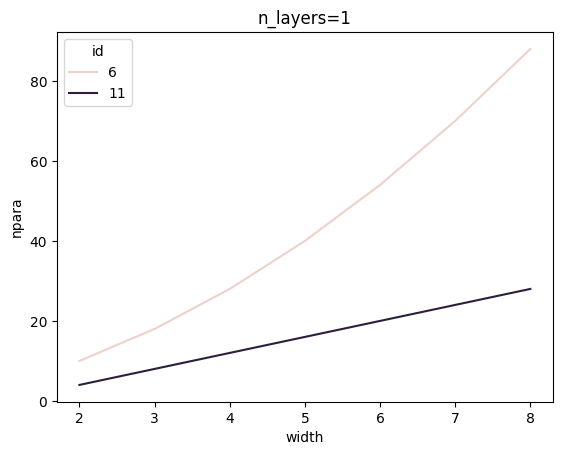

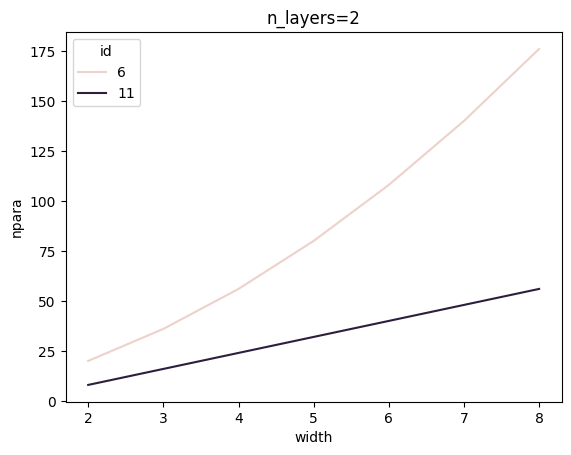

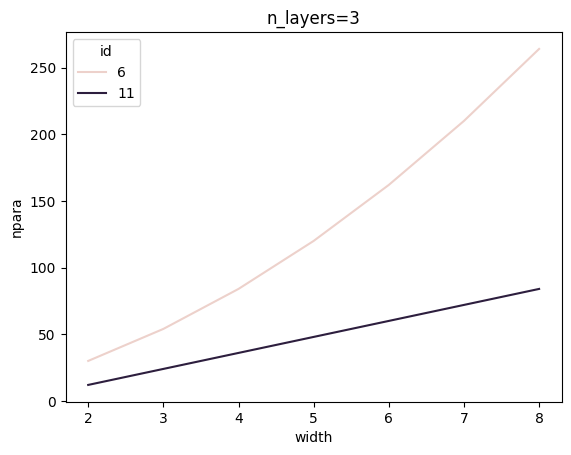

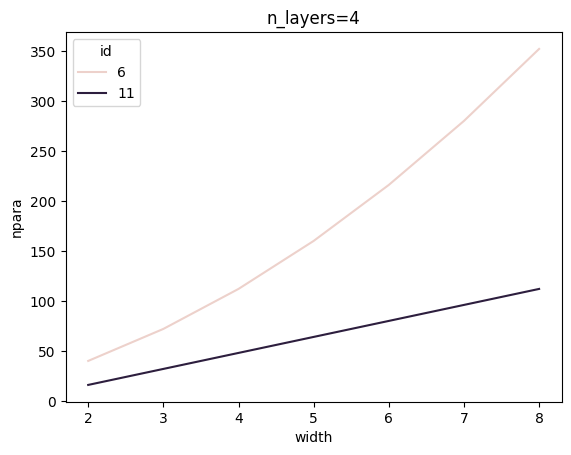

In [10]:
# for b in w:
#     sns.scatterplot( y=df[df.width==b ].npara,x=df[df.width==b ].layers,hue=df['id'])
#     plt.title(f'n_qubit={b}')
#     plt.show()
for b in l:
    sns.lineplot( y=df[df.layers==b ].npara,x=df[df.layers==b ].width,hue=df['id'])
    plt.title(f'n_layers={b}')
    plt.show()


In [11]:
4//2*2

4